# MEAN-SQUARED ERROR AVEC UN MODELE XGBOOST TARGET SIMPLE

In [1]:
import pandas as pd
import numpy as np
import panel as pn

data = pd.read_csv('result_requetes.csv')
#data.head()

In [2]:
#On affecte le bon type aux variables qualitatives
data["city"]=pd.Categorical(data["city"],ordered=False)
data["language"]=pd.Categorical(data["language"],ordered=False)
data["group"]=pd.Categorical(data["group"],ordered=False)
data["brand"]=pd.Categorical(data["brand"],ordered=False)

data["mobile"]=pd.Categorical(data["mobile"],ordered=False)
data["parking"]=pd.Categorical(data["parking"],ordered=False)
data["pool"]=pd.Categorical(data["pool"],ordered=False)
data["children_policy"]=pd.Categorical(data["children_policy"],ordered=False)

data["hotel_id"]=pd.Categorical(data["hotel_id"],ordered=False)
data["avatar_id"]=pd.Categorical(data["avatar_id"],ordered=False)

data["price"]=pd.DataFrame(data["price"], dtype=float)

#data.dtypes
#data.head()

## TARGET ENCODING

Avec TargetEncoder / MEstimateEncoder

In [ ]:
#!pip install category_encoders > /dev/null 2>&1   EN LOCAL ?!

In [3]:
from category_encoders import TargetEncoder
from category_encoders import MEstimateEncoder

In [4]:
Y = data[["price"]]

In [5]:
X = data[["nb_requete","date","stock","city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]

NE PAS EXECUTER LES 2 CELLULES SUIVANTES

In [ ]:
#X=data[["city","language","mobile","hotel_id","group","brand","parking","pool","children_policy"]]
#enc = TargetEncoder()
#enc = MEstimateEncoder()
#Xenc = enc.fit_transform(X,Y)
#dataDum=pd.DataFrame(Xenc,columns=enc.get_feature_names())
#dataDum

In [ ]:
#dataQuant = data[["nb_requete","date","stock"]]
#dfC = pd.concat([dataQuant,dataDum],axis=1)
#dfC

In [6]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(dfC, Y, test_size=0.1, random_state=0)

In [7]:
#y_train = np.ravel(y_train)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

rf = make_pipeline(
    #TargetEncoder(),
    MEstimateEncoder(),
    StandardScaler(),
    RandomForestRegressor(),
)

xgb = make_pipeline(
    #TargetEncoder(),
    MEstimateEncoder(),
    StandardScaler(),
    #GradientBoostingRegressor(),
    GradientBoostingRegressor(n_estimators=300,max_depth=10),
)

In [ ]:
#xgb.fit(X_train, y_train)

In [ ]:
#print(f"XGB score: {xgb.score(X_test, y_test):.2f}")

## MSE en fonction de la date pour B folds

In [9]:
import matplotlib.pyplot as plt

In [10]:
date = np.linspace(0,44,45)
B = 10
Vect_erreur = np.zeros((B,len(date),2))

for b in range(0,B):
    #X_train, X_test, y_train, y_test = train_test_split(dfC,Y,test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    xgb.fit(X_train, y_train)
    pred = xgb.predict(X_test)

    x = np.ravel(X_test[['date']])

    for i in range(len(x)):
        d = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,d,0] += erreur
        Vect_erreur[b,d,1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [11]:
arrayErreur = np.zeros((B,45))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]
    #for d in range(0,45):
    #    arrayErreur[b,d] = Vect_erreur[b,d,0]
#arrayErreur

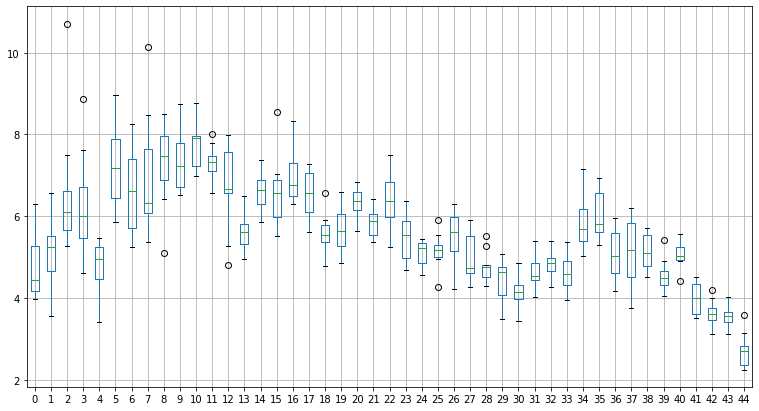

In [12]:
dataframeErreur = pd.DataFrame(arrayErreur)
plt.figure(figsize=(13,7))
dataframeErreur.boxplot()
plt.show()

## MSE en fonction de la ville pour B folds

In [15]:
listCity = {'amsterdam':0, 'copenhagen':1, 'madrid':2, 'paris':3, 'rome':4, 'sofia':5, 'valletta':6, 'vienna':7, 'vilnius':8}
B = 10
Vect_erreur = np.zeros((B,len(listCity),2))

In [16]:
for b in range(0,B):
    #X_train, X_test, y_train, y_test = train_test_split(dfC,Y,test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    xgb.fit(X_train, y_train)
    pred = xgb.predict(X_test)

    x = np.ravel(X_test[['city']])
    
    for i in range(len(x)):
        c = x[i]
        yt = y_test[i]
        p = pred[i]
        erreur = (yt-p)**2
        Vect_erreur[b,listCity[c],0] += erreur
        Vect_erreur[b,listCity[c],1] += 1

    for i in range(Vect_erreur.shape[1]):
        Vect_erreur[b,i,0] = Vect_erreur[b,i,0]/Vect_erreur[b,i,1] 

In [17]:
arrayErreur = np.zeros((B,len(listCity)))
for b in range(B):
    arrayErreur[b,:]=Vect_erreur[b,:,0]
    #for d in range(0,45):
    #    arrayErreur[b,d] = Vect_erreur[b,d,0]
#arrayErreur

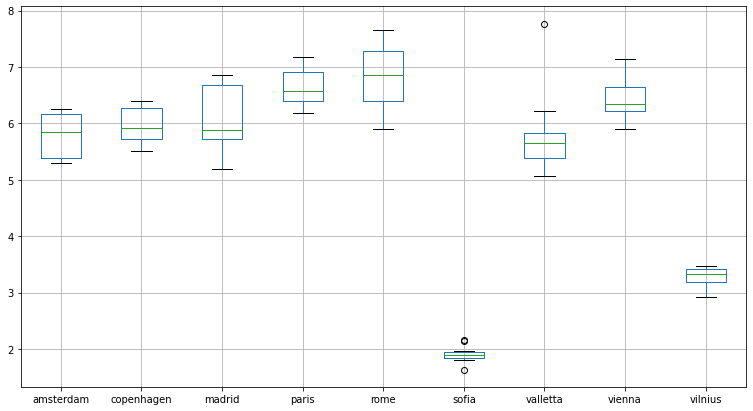

In [18]:
dataframeErreur = pd.DataFrame(arrayErreur,columns=['amsterdam', 'copenhagen', 'madrid', 'paris', 'rome', 'sofia', 'valletta', 'vienna', 'vilnius'])
plt.figure(figsize=(13,7))
dataframeErreur[['amsterdam', 'copenhagen', 'madrid', 'paris', 'rome', 'sofia', 'valletta', 'vienna', 'vilnius']].boxplot(return_type='dict')
plt.show()